In [1]:
#기본
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import requests
import seaborn as sns
import warnings


#전처리
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler

#모델
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import lightgbm as lgbm
import xgboost as xgb
import catboost as cat

In [2]:
warnings.filterwarnings("ignore")
#시드고정
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(84)

# 1. 데이터 불러오기

RPG 게임의 기본적인 틀을 마련해준 D&D의 API를 이용해서 학습하려고 한다. <p>
우선은 기본적으로 몬스터의 데이터를 이용해 몬스터의 특성에 따라 xp(경험치)를 어느정도로 설정해야할지 알려주는 모델을 구축한다. <p>
http://www.dnd5eapi.co/ (해당 API의 정보는 D&D 5판을 기준으로 하고 있다.) 

In [3]:
# API 사이트 URL 지정
api_url = "https://www.dnd5eapi.co"
monsters_url = api_url + "/api/monsters/"

# 전체 몬스터 목록 요청하기
response = requests.get(monsters_url)
data_json = response.json()
monster_list = []

#각 몬스터들 세부사항 URL 모음
monsters_urls = []
for i in range(0,data_json['count']) :
    monsters_urls.append(monsters_url + data_json['results'][i]['index'])

# 각 몬스터의 스탯을 추출하여 데이터 프레임에 붙이기
for monster in monsters_urls:
    # monster_url = api_url + monster['url']
    monster_response = requests.get(monster)
    monster_data = monster_response.json()

    monster_list.append({'index': monster_data["index"], 'name' : monster_data["name"],
                        'hp' : monster_data["hit_points"], 'str' : monster_data["strength"],
                        'dex' : monster_data["dexterity"], 'con' : monster_data["constitution"],
                        'int' : monster_data["intelligence"], 'wis' : monster_data["wisdom"], 
                        'cha' : monster_data["charisma"], 'type' : monster_data["type"], 
                        'cr' : monster_data["challenge_rating"], 'xp' : monster_data["xp"]})
monster_df = pd.DataFrame(monster_list)

In [4]:
monster_df.set_index('index', inplace = True)

In [5]:
monster_df
monster_df = monster_df.drop('name', axis=1) #이름은 index와 동일하고 학습에 사용할 이유가 없으므로 제외

hp : hit_point 얼마나 때려야하는지를 나타내는 수치(체력과 비슷) <p>
str : strength 근력 <p>
dex : dexerity 민첩 <p>
con : constitution 건강 <p>
int : intelligence 지능 <p>
wis : wisdom 지혜 <p>
cha : charisma 매력 <p>
type : type 몬스터 타입(종족 등) <p>
xp : 경험치 <p>
\*\* CR : challenge_rating 몬스터의 강함을 나타낸 수치 (21 이상은 보통 에픽몬스터로 취급)

# 2. EDA

<AxesSubplot: >

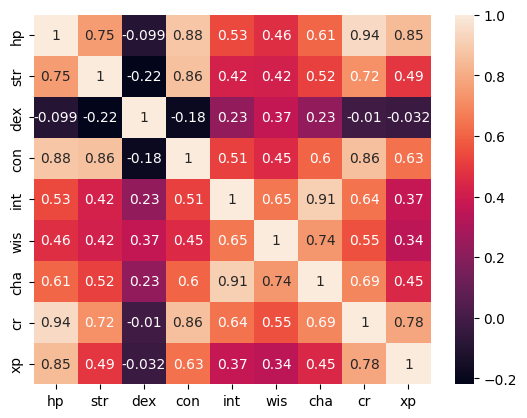

In [6]:
sns.heatmap(monster_df.corr(), annot=True)

xp와 가장 상관관계가 높은건 hp와 constitution이다. 그외 int와 cha, str와 hp, hp와 con, cha와 wis 등이 상관관계가 높다.

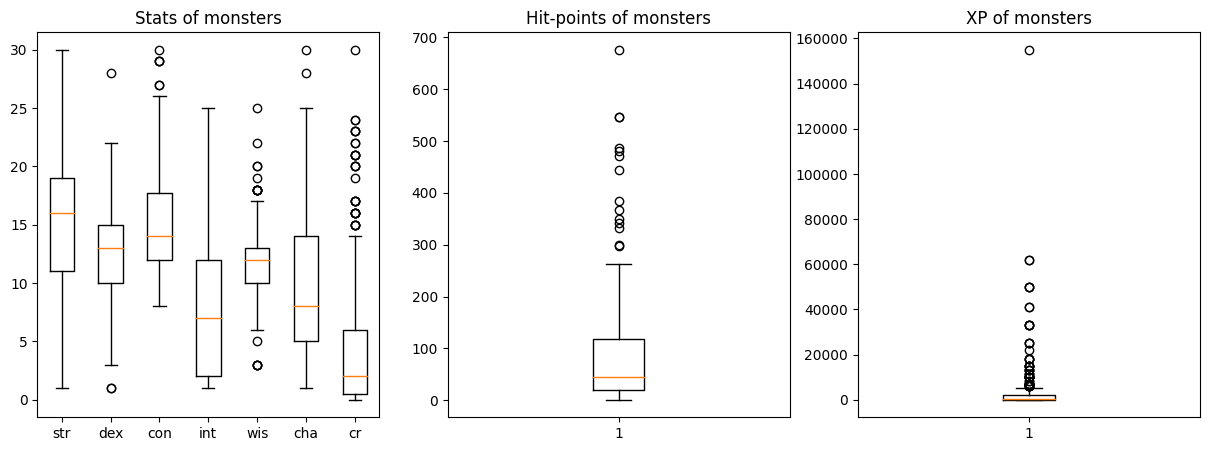

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,5))

monster_num = monster_df.drop('type', axis=1)
numcol = monster_num.columns.drop('xp')

ax1.boxplot(monster_num.drop(['xp','hp'], axis=1))
ax1.set_title('Stats of monsters')
ax1.set_xticklabels(monster_num.drop(['xp','hp'], axis=1).columns)

ax2.boxplot(monster_num[['hp']])
ax2.set_title('Hit-points of monsters')

ax3.boxplot(monster_num[['xp']])
ax3.set_title('XP of monsters')

plt.show()

이상치가 감지된다. 특히 HP와 XP에서 큰 범위의 이상치를 가진것으로 보인다. 일반적으로 조우하기 어려운 특수한 몬스터일 가능성이 있으므로 제외할 수 있다. <p>
특히 왜도가 높은 HP가 대충 300 언저리에서 이상치로 판단되고 있으므로 hp를 기준으로 몬스터를 데이터에서 제외하고 학습할 수 있다.

# 3. 데이터 전처리

### 결측치, 이상치 처리

In [8]:
# 결측치 확인
monster_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 334 entries, aboleth to zombie
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   hp      334 non-null    int64  
 1   str     334 non-null    int64  
 2   dex     334 non-null    int64  
 3   con     334 non-null    int64  
 4   int     334 non-null    int64  
 5   wis     334 non-null    int64  
 6   cha     334 non-null    int64  
 7   type    334 non-null    object 
 8   cr      334 non-null    float64
 9   xp      334 non-null    int64  
dtypes: float64(1), int64(8), object(1)
memory usage: 28.7+ KB


In [9]:
for i in monster_df.drop(['type'], axis=1):
    print(i, '=========================')
    print('  Minimum :', monster_df[i].min(), '  Maximum :', monster_df[i].max())
    print("")

hp =========================
  Minimum : 1   Maximum : 676

str =========================
  Minimum : 1   Maximum : 30

dex =========================
  Minimum : 1   Maximum : 28

con =========================
  Minimum : 8   Maximum : 30

int =========================
  Minimum : 1   Maximum : 25

wis =========================
  Minimum : 3   Maximum : 25

cha =========================
  Minimum : 1   Maximum : 30

cr =========================
  Minimum : 0.0   Maximum : 30.0

xp =========================
  Minimum : 0   Maximum : 155000



결측치는 없으며 스탯은 몬스터 최대 수치인 1 ~ 30까지만 있으므로 기입 오류와 같은 실수에 의한 이상치는 없다고 판단. 박스플롯에서 이상치로 의심되는 데이터들이 있으나 hp와 xp가 똑같이 오른쪽으로 꼬리가 긴 분포이고 상관관계가 높았으므로 회귀 분석 후에 처리할 것을 결정함. hp가 단위가 크므로 표준화를 고려할 수 있음. <p>
\* 회귀분석 후 데이터의 AIC BIC가 상당히 높아 모델이 복잡하고 첨도가 매우 높아 이상치의 영향이 크므로 제거하기로 고려함. <p>
\*\* 이후에도 

In [10]:
#이상치 제거
outlyers = monster_df[monster_df['cr'] >= 21].index
monster_df[monster_df['cr'] >= 21]

,hp,str,dex,con,int,wis,cha,type,cr,xp
index,,,,,,,,,,
ancient-black-dragon,367,27,14,25,16,15,19,dragon,21.0,33000
ancient-blue-dragon,481,29,10,27,18,17,21,dragon,23.0,50000
ancient-bronze-dragon,444,29,10,27,18,17,21,dragon,22.0,41000
ancient-copper-dragon,350,27,12,25,20,17,19,dragon,21.0,33000
ancient-gold-dragon,546,30,14,29,18,17,28,dragon,24.0,62000
ancient-green-dragon,385,27,12,25,20,17,19,dragon,22.0,41000
ancient-red-dragon,546,30,10,29,18,15,23,dragon,24.0,62000
ancient-silver-dragon,487,30,10,29,18,15,23,dragon,23.0,50000
kraken,472,30,11,25,22,18,20,monstrosity,23.0,50000


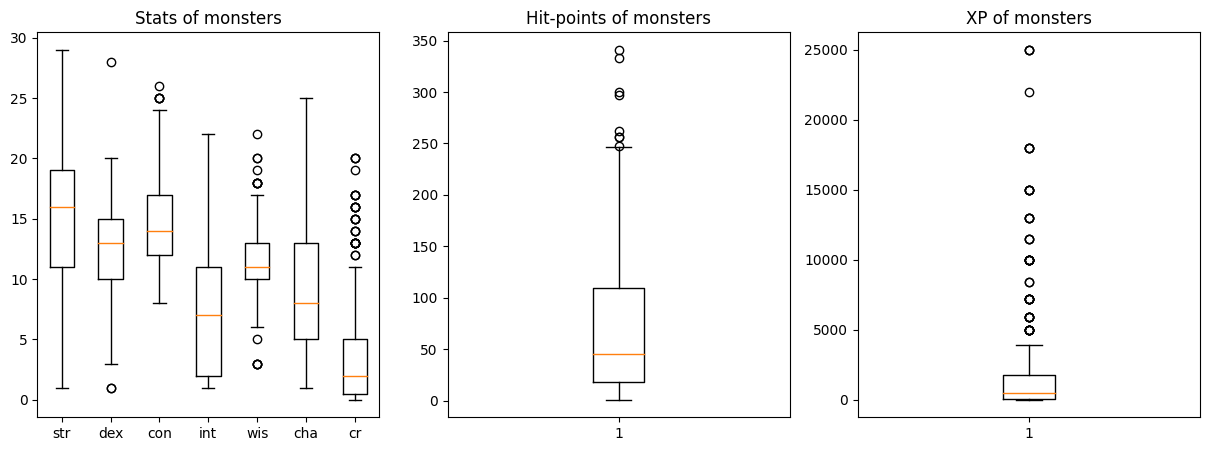

In [11]:
monster_df_in = monster_df.drop(outlyers, axis=0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,5))

monster_num_in = monster_df_in.drop('type', axis=1)

ax1.boxplot(monster_num_in.drop(['xp','hp'], axis=1))
ax1.set_title('Stats of monsters')
ax1.set_xticklabels(monster_num_in.drop(['xp','hp'], axis=1).columns)

ax2.boxplot(monster_num_in[['hp']])
ax2.set_title('Hit-points of monsters')

ax3.boxplot(monster_num_in[['xp']])
ax3.set_title('XP of monsters')

plt.show()

hp 이외에 이상치가 많은 것으로 나타난 wisdom이나 con은 박스플롯에서 맥시범이 각각 17, 26 정도였는데 이상치로 감지된 몬스터들은 모두 그만큼의 높은 스탯을 지닌것을 보인다. <p>
대부분이 (상대하기 어려운)에픽 몬스터급이며 에인션트 드래곤이 대부분인 것을 확인할 수 있다. 그리고 특히 'Tarrasque'같은 경우에는 5판에서 가장 CR(몬스터의 강함 수치)이 높으며 일반적인 전투로는 상대하기 어려운 몬스터로 데이터에서 이상치로 판단할 수 있다.

### 데이터 분할

In [12]:
# #이상치 처리 전
# X_monster = monster_df.drop('xp', axis=1)
# y_monster = monster_df['xp']

# X_train, X_temp, y_train, y_temp = train_test_split(X_monster, y_monster, test_size=0.4)
# X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.4)

In [13]:
#이상치 처리 후
X_monster = monster_df_in.drop('xp', axis=1)
y_monster = monster_df_in['xp']

X_train, X_temp, y_train, y_temp = train_test_split(X_monster, y_monster, test_size=0.4)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.4)

### 로그변환 (회귀분석 후 결정)

In [14]:
# #로그변환
# X_monster_log = X_monster.drop('type', axis=1).copy()
# X_monster_log[['int','cha','hp']] = np.log(X_monster_log[['int','cha','hp']])

### 범주형 변수 처리

In [119]:
# #범주형 변수 One-Hot Encoding - 선형모델에서 사용
# ohe = OneHotEncoder(sparse_output=False)
# X_train_oh = ohe.fit_transform(X_train[['type']])
# X_valid_oh = ohe.transform(X_valid[['type']])
# X_test_oh = ohe.transform(X_test[['type']])

# 스케일링
scaler = StandardScaler()
# scaler = MinMaxScaler()

X_train_s = scaler.fit_transform(X_train[numcol])
X_valid_s = scaler.transform(X_valid[numcol])
X_test_s = scaler.transform(X_test[numcol])

# #스케일링 적용 후 다시 원형으로 결합
# X_train_ohs = np.concatenate((X_train_oh, X_train_s), axis=1)
# X_valid_ohs = np.concatenate((X_valid_oh, X_valid_s), axis=1)
# X_test_ohs = np.concatenate((X_test_oh, X_test_s), axis=1)

In [120]:
#범주형 변수 Label Encoding - 트리모델에서 사용
le = LabelEncoder()
X_train_le = le.fit_transform(X_train[['type']])
X_valid_le = le.transform(X_valid[['type']])
X_test_le = le.transform(X_test[['type']])

#스탠다드 스케일링 적용 후 다시 원형으로 결합
#수치형 변수들은 동일하게 처리되었으므로 다시 수행하지 않음

X_train_les = np.concatenate((X_train_le.reshape(-1, 1), X_train_s), axis=1)
X_valid_les = np.concatenate((X_valid_le.reshape(-1, 1), X_valid_s), axis=1)
X_test_les = np.concatenate((X_test_le.reshape(-1, 1), X_test_s), axis=1)

X_train_cat = np.concatenate((X_train[['type']], X_train_s), axis=1)
X_valid_cat = np.concatenate((X_valid[['type']], X_valid_s), axis=1)
X_test_cat = np.concatenate((X_test[['type']], X_test_s), axis=1)

In [121]:
#라벨 인코딩 결과
le_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
le_mapping

{'aberration': 0,
 'beast': 1,
 'celestial': 2,
 'construct': 3,
 'dragon': 4,
 'elemental': 5,
 'fey': 6,
 'fiend': 7,
 'giant': 8,
 'humanoid': 9,
 'monstrosity': 10,
 'ooze': 11,
 'plant': 12,
 'swarm of Tiny beasts': 13,
 'undead': 14}

In [122]:
X_train_s = pd.DataFrame(X_train_s)
X_train_s.columns = numcol
X_train_s.index = y_train.index

X_valid_s = pd.DataFrame(X_valid_s)
X_valid_s.columns = numcol
X_valid_s.index = y_valid.index

X_test_s = pd.DataFrame(X_test_s)
X_test_s.columns = numcol
X_test_s.index = y_test.index

In [123]:
X_monster_s = pd.DataFrame(scaler.fit_transform(X_monster.drop('type', axis = 1))) #로그변환 X
# X_monster_s = pd.DataFrame(scaler.fit_transform(X_monster_log)) #로그변환 O
X_monster_s.columns = numcol
X_monster_s.index = y_monster.index
X_monster_s

,hp,str,dex,con,int,wis,cha,cr
index,,,,,,,,
aboleth,0.973087,1.000467,-1.148306,0.081899,1.972315,1.277743,1.630926,1.313658
acolyte,-0.883925,-0.759044,-0.834156,-1.198268,0.467819,0.910719,0.315211,-0.776544
adult-black-dragon,1.857378,1.320378,0.422444,1.618099,1.220067,0.543696,1.442967,2.171177
adult-blue-dragon,2.299523,1.640289,-0.834156,2.130165,1.596191,1.277743,1.818885,2.599937
adult-brass-dragon,1.518400,1.320378,-0.834156,1.618099,1.220067,0.543696,1.442967,1.956798
...,...,...,...,...,...,...,...,...
young-green-dragon,0.987825,0.680556,-0.205856,0.593965,1.596191,0.543696,1.067048,0.884899
young-red-dragon,1.606829,1.320378,-0.834156,1.618099,1.220067,-0.190351,1.818885,1.313658
young-silver-dragon,1.459447,1.320378,-0.834156,1.618099,1.220067,-0.190351,1.818885,1.099279


# 4. 모델학습

### 다중선형회귀분석 (전체 데이터)

In [124]:
ols_model = sm.OLS(pd.DataFrame(y_monster), sm.add_constant(X_monster_s)).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     xp   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     361.3
Date:                Wed, 06 Sep 2023   Prob (F-statistic):          4.05e-153
Time:                        18:41:28   Log-Likelihood:                -2783.8
No. Observations:                 322   AIC:                             5586.
Df Residuals:                     313   BIC:                             5620.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2306.1957     77.743     29.664      0.000    2153.231    2459.160
hp          -134.9422    302.391     -0.446      0.656    -729.918     460.034
str         -419.9667    150.393     -2.792      0.006    -715.875    -124.058
dex         -195.9678     94.053     -2.084      0.038    -381.025     -10.911
con         -602.6249    202.268     -2.979      0.003   -1000.602    -204.647
int         -649.7126    182.495     -3.560      0.000   -1008.785    -290.640
wis            3.6605    118.453      0.031      0.975    -229.404     236.725
cha          472.2022    209.361      2.255      0.025      60.269     884.136
cr          5130.1047    269.346     19.047      0.000    4600.146    5660.063
==============================================================================
Omnibus:                      161.822   Durbin-Watson:                   1.486
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1409.766
Skew:                           1.882   Prob(JB):                    7.47e-307
Kurtosis:                      12.534   Cond. No.                         10.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

첨도가 상당히 높고 왜도가 높아 오른쪽으로 꼬리가 긴 형태가 만들어져있다. 첨도는 이상치가 원인이며 왜도는 몬스터들 특성상 강력한 몬스터보다 비교적 약한 몬스터들이 수가 많은 것이 원인이라고 파악된다.<p>
(로그변환 후) R, 수정된 R이 상당히 낮게 나왔고 AIC, BIC는 변함없이 높았으므로 로그변환으로 인해 크게 성능을 내는 효과를 보기 어려웠다고 판단함.
(이상치 제거 후) 이상치 제거 후에 첨도는 상당히 낮아졌으나 성능에는 그다지 영향을 미치지 못했고 로그우도나 AIC BIC 또한 크게 달라졌다고 보기 힘드므로 선형회귀는 적절하지 않다고 판단.

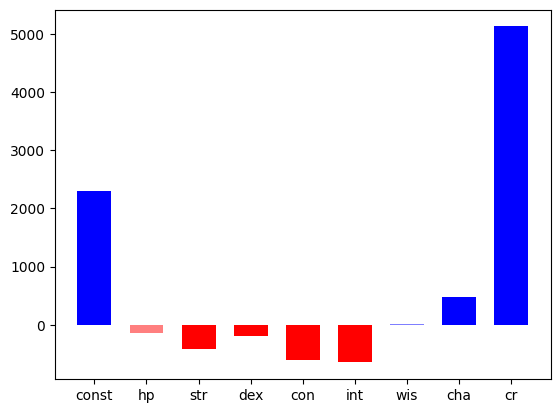

In [125]:
ols_result = pd.DataFrame(ols_model.summary().tables[1].data)
ols_result = ols_result.rename(columns = ols_result.iloc[0]).drop(ols_result.index[0])


color = ['blue' if p >= 0 else 'red' for p in ols_result['coef'].astype(float)]
alpha = [0.5 if p > 0.05 else 1 for p in ols_result['P>|t|'].astype(float)]
# plt.bar(ols_result.iloc[:,0],ols_result['coef'].astype(float), alpha = alpha, color = color)

for i, coef in enumerate(ols_result['coef'].astype(float)):
    plt.bar(ols_result.iloc[i,0], coef, 0.65, alpha = alpha[i], color = color[i])
plt.show()

막대의 길이 : 길수록 독립변수가 미치는 종속변수에 미치는 영향 <p>
막대의 색깔 : 파란색 = 양수, 빨간색 = 음수 <p>
막대의 진함 : 짙음 = 유의함, 옅음 = 유의하지 않음

\*\* CR이 상당히 유의하며 회귀계수가 매우 높게 나타났다. 

### 트리기반모델

#### Light GBM

In [126]:
pd.DataFrame(X_train_les)

,0,1,2,3,4,5,6,7,8
0,1.0,-0.945148,-1.952286,0.317722,-1.643228,-1.045796,0.086089,-0.634721,-0.801420
1,1.0,-0.945148,-1.952286,0.622799,-1.643228,-1.045796,0.086089,-0.989796,-0.801420
2,13.0,-0.655230,-1.796006,0.012646,-1.141419,-1.227796,-1.609342,-1.522410,-0.701356
3,1.0,-0.807092,0.079355,-0.902584,-0.388707,-1.045796,-0.252997,-0.457183,-0.776404
4,9.0,-0.655230,-0.076925,-0.292431,-0.890515,-0.317794,-0.592083,-0.457183,-0.701356
...,...,...,...,...,...,...,...,...,...
188,1.0,-0.696647,0.079355,-0.902584,-0.388707,-1.045796,-0.592083,-0.812258,-0.701356
189,1.0,-0.130617,0.704475,0.317722,-0.639611,-1.227796,-0.592083,-1.167334,-0.401164
190,1.0,-0.779481,-0.076925,0.622799,-1.141419,-0.863795,0.764262,-0.457183,-0.751388
191,4.0,1.139500,1.017035,-0.902584,1.116719,1.138210,0.425176,1.318195,0.999733


In [127]:
lgbm_param = {
    'boosting_type': ['dart', 'gbdt' ,'rf'],
    'num_leaves' : list(range(10, 100, 1)),
    'min_child_weight': list(range(1, 10, 1)),
    'learning_rate' : list(np.arange(0.001, 0.1, 0.001)),
    'max_depth': list(range(1, 10, 1 )),
    'subsample': list(np.arange(0.6, 1, 0.05)),
    'alpha' : [0, 0.001, 0.01, 0.1, 1, 10],
    'lambda' : [0, 0.001, 0.01, 0.1, 1, 10]
}

lgbm_grid = RandomizedSearchCV(
    estimator = lgbm.LGBMRegressor(n_estimators=500),
    param_distributions=lgbm_param,
    n_jobs=-1,
    cv=3,
    refit=True,
    verbose=1,
    n_iter=50,
    scoring="neg_mean_squared_error"
    )


evaluation = [(X_train_les, y_train), (X_valid_les, y_valid)]
lgbm_grid.fit(X_train_les, y_train, eval_set=evaluation)

lgbm_model = lgbm_grid.best_estimator_
lgbm_model.fit(X_train_les, y_train)
lgbm_pred = lgbm_model.predict(X_test_les)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.001. Current value: lambda_l2=0.001
[1]	training's l2: 2.48067e+07	valid_1's l2: 1.27262e+07
[2]	training's l2: 2.45484e+07	valid_1's l2: 1.25346e+07
[3]	training's l2: 2.42933e+07	valid_1's l2: 1.23456e+07
[4]	training's l2: 2.40411e+07	valid_1's l2: 1.21594e+07
[5]	training's l2: 2.3792e+07	valid_1's l2: 1.19757e+07
[6]	training's l2: 2.35459e+07	valid_1's l2: 1.17946e+07
[7]	training's l2: 2.33028e+07	valid_1's l2: 1.16161e+07
[8]	training's l2: 2.30625e+07	valid_1's l2: 1.14401e+07
[9]	training's l2: 2.28251e+07	valid_1's l2: 1.12666e+07
[10]	training's l2: 2.25906e+07	valid_1's l2: 1.10955e+07
[11]	training's l2: 2.23586e+07	valid_1's l2: 1.09265e+07
[12]	training's l2: 2.21296e+07	valid_1's l2: 1.07602e+07
[13]	training's l2: 2.19032e+07	valid_1's l2: 1.0596e+07
[14]	training's l2: 2.16795e+07	valid_1's l2: 1.0434e+07
[15]	training's l2: 2.14584e+07	valid_1's l2: 1.02744e+07
[16]	training's 

In [128]:
lgbm_model.booster_.save_model("lgbm_model.model")
print('RMSE ::: \n ', np.sqrt(mean_squared_error(y_test, lgbm_pred)))

RMSE ::: 
  836.714802388101


#### XGBoost

In [129]:
xgb_param = {
    'booster': ['gbtree', 'gblinear', 'dart'],
    'max_depth' : list(range(1,10,1)),
    'learning_rate' : list(np.arange(0.001, 0.1, 0.001)),
    'min_child_weight': list(range(1, 10, 1)),
    'subsample': list(np.arange(0.6, 1, 0.05)),
    'reg_alpha': [0, 0.001, 0.01, 0.1, 1, 10],
    'reg_lambda': [0, 0.001, 0.01, 0.1, 1, 10]
}

xgb_grid = RandomizedSearchCV(
    estimator = xgb.XGBRegressor(n_estimators=500),
    param_distributions=xgb_param,
    n_jobs=-1,
    cv=3,
    refit=True,
    verbose=1,
    n_iter=50,
    scoring="neg_mean_squared_error"
    )

xgb_grid.fit(X_train_les, y_train, eval_set=evaluation)

xgb_model = xgb_grid.best_estimator_
xgb_model.fit(X_train_les, y_train)
xgb_pred = xgb_model.predict(X_test_les)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[0]	validation_0-rmse:5172.58158	validation_1-rmse:3787.47263
[1]	validation_0-rmse:4736.08685	validation_1-rmse:3452.24473
[2]	validation_0-rmse:4337.56003	validation_1-rmse:3155.97643
[3]	validation_0-rmse:3973.39349	validation_1-rmse:2889.11469
[4]	validation_0-rmse:3632.25138	validation_1-rmse:2638.97793
[5]	validation_0-rmse:3329.80951	validation_1-rmse:2408.06861
[6]	validation_0-rmse:3047.80212	validation_1-rmse:2203.32719
[7]	validation_0-rmse:2789.59938	validation_1-rmse:2002.87695
[8]	validation_0-rmse:2568.92502	validation_1-rmse:1823.76930
[9]	validation_0-rmse:2349.86440	validation_1-rmse:1656.10134
[10]	validation_0-rmse:2155.37944	validation_1-rmse:1517.33410
[11]	validation_0-rmse:1976.09888	validation_1-rmse:1383.87862
[12]	validation_0-rmse:1808.26539	validation_1-rmse:1256.34480
[13]	validation_0-rmse:1657.68312	validation_1-rmse:1144.55076
[14]	validation_0-rmse:1513.91345	validation_1-rmse:1045.10565
[15

In [130]:
xgb_model.save_model("xgb_model.model")
print('RMSE ::: \n ', np.sqrt(mean_squared_error(y_test, xgb_pred)))

RMSE ::: 
  210.28824361452374


\*\* 결측치 hp >= 300 기준으로 했을 떄 : RMSE ::: 82.03108429411083 <p>
\*\*\* 결측치 cr >= 21 기준을 했을 때 : RMSE ::: 22.29660442251907

#### CatBoost

In [131]:
pd.DataFrame(X_train_cat)

,0,1,2,3,4,5,6,7,8
0,beast,-0.945148,-1.952286,0.317722,-1.643228,-1.045796,0.086089,-0.634721,-0.80142
1,beast,-0.945148,-1.952286,0.622799,-1.643228,-1.045796,0.086089,-0.989796,-0.80142
2,swarm of Tiny beasts,-0.65523,-1.796006,0.012646,-1.141419,-1.227796,-1.609342,-1.52241,-0.701356
3,beast,-0.807092,0.079355,-0.902584,-0.388707,-1.045796,-0.252997,-0.457183,-0.776404
4,humanoid,-0.65523,-0.076925,-0.292431,-0.890515,-0.317794,-0.592083,-0.457183,-0.701356
...,...,...,...,...,...,...,...,...,...
188,beast,-0.696647,0.079355,-0.902584,-0.388707,-1.045796,-0.592083,-0.812258,-0.701356
189,beast,-0.130617,0.704475,0.317722,-0.639611,-1.227796,-0.592083,-1.167334,-0.401164
190,beast,-0.779481,-0.076925,0.622799,-1.141419,-0.863795,0.764262,-0.457183,-0.751388
191,dragon,1.1395,1.017035,-0.902584,1.116719,1.13821,0.425176,1.318195,0.999733


In [132]:
cat_param = {
    'boosting_type': ['gbtree', 'Dart', 'Plain', 'Ordered', 'Bernoulli', 'Poisson'],
    'depth' : list(range(1,10,1)),
    'learning_rate' : list(np.arange(0.001, 0.1, 0.001)),
    'subsample': list(np.arange(0.6, 1, 0.05)),
}

cat_grid = RandomizedSearchCV(
    estimator = cat.CatBoostRegressor(n_estimators=500, cat_features= [0]),
    param_distributions=cat_param,
    n_jobs=-1,
    cv=3,
    refit=True,
    verbose=1,
    n_iter=50,
    scoring="neg_mean_squared_error"
    )

cat_grid.fit(X_train_cat, y_train, eval_set = (X_valid_cat, y_valid))

cat_model = cat_grid.best_estimator_
cat_model.fit(X_train_cat, y_train)
cat_pred = cat_model.predict(X_test_cat)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


0:	learn: 4840.5934811	test: 3447.9352812	best: 3447.9352812 (0)	total: 6.32ms	remaining: 3.15s
1:	learn: 4693.7649488	test: 3316.1228243	best: 3316.1228243 (1)	total: 12.1ms	remaining: 3.02s
2:	learn: 4517.2028004	test: 3193.8025669	best: 3193.8025669 (2)	total: 17ms	remaining: 2.81s
3:	learn: 4354.3088387	test: 3041.4229753	best: 3041.4229753 (3)	total: 25.7ms	remaining: 3.18s
4:	learn: 4194.2117650	test: 2873.4866523	best: 2873.4866523 (4)	total: 34.4ms	remaining: 3.4s
5:	learn: 4043.3079416	test: 2743.3697416	best: 2743.3697416 (5)	total: 43.1ms	remaining: 3.55s
6:	learn: 3906.5760598	test: 2631.6268573	best: 2631.6268573 (6)	total: 51.7ms	remaining: 3.64s
7:	learn: 3775.2660661	test: 2526.2890420	best: 2526.2890420 (7)	total: 60.8ms	remaining: 3.74s
8:	learn: 3639.8339669	test: 2395.7686401	best: 2395.7686401 (8)	total: 69.6ms	remaining: 3.8s
9:	learn: 3513.8434152	test: 2289.1676208	best: 2289.1676208 (9)	total: 79.6ms	remaining: 3.9s
10:	learn: 3372.5295960	test: 2186.9932825	be

In [133]:
cat_model.save_model("cat_model.model")
print('RMSE ::: \n ', np.sqrt(mean_squared_error(y_test, cat_pred)))

RMSE ::: 
  246.0795363851899


#### 성능비교

In [134]:
print("Y값의 중위값 : \n   ", y_monster.median())
print("Y값의 사분위수 : \n   ", "Q1 = ", np.percentile(y_monster, 25), " ,   Q3 = ",np.percentile(y_monster, 75))
print("Y값의 평균 : \n   ", y_monster.mean())
print("Y값의 표준편차 : \n   ", y_monster.std())

Y값의 중위값 : 
    450.0
Y값의 사분위수 : 
    Q1 =  62.5  ,   Q3 =  1800.0
Y값의 평균 : 
    2306.195652173913
Y값의 표준편차 : 
    4407.181008108981


\* 1차적으로 RMSE가 상당히 높게 나타남. 중위값이 1000미만임에 비해서 RSME가 1000이상인 것은 강한 몬스터들이 많은 xp를 주는 이상치가 관여했기 때문이라고 예측. 따라서 CR을 추가해 21을 기준으로 에픽몬스터를 제외하고 일반 몬스터를 기준으로 학습할 수 있도록 조정하도록 <p>
\*\* 기존의 이상치 처리 방식은 동일하게 하고 CR만 추가했을때 XGBoost가 82로 가장 낮았고 나머지는 lgbm, cat 각각 988, 618나왔다. xgboost의 모델을 일단 저장하도록 했다. 다음 시도에 CR 기준으로 이상치 제거를 한 뒤 시도해볼 것. <p>
\*\*\* CR을 변수로 추가한 뒤에 기존처럼 HP를 기준으로 이상치제거 한 방법과 CR을 기준으로 이상치 제거하는 방법 둘 다 사용. 두 방식 모두 XGBoost가 가장 낮은 RMSE를 나타냈다. 각각 약 82.0, 22.3로 CR을 기준으로 한 것이 가장 낮아 성능이 높았다. Catboost와 LightGBM은 대체로 200 이상이나 네자리까지 가는 경우도 있었다. 이는 두 부스팅 기법이 데이터가 수가 적을때 과적합되는 경우가 많기 때문이라고 볼 수 있다.<p>
IQR(Q3-Q1)이 1,737.5이고 표준편차가 높은 왜도에 의해 크므로 22.3의 RMSE는 충분한 성능을 낼 수 있는 모델이라고 판단하였다.

# 5. 새로운 데이터 입력

모델을 활용하기 위해 새로운 몬스터를 만드는 것을 가정하고 적절한 경험치를 예측한다.

In [135]:
#라벨 인코딩 결과
le_mapping

{'aberration': 0,
 'beast': 1,
 'celestial': 2,
 'construct': 3,
 'dragon': 4,
 'elemental': 5,
 'fey': 6,
 'fiend': 7,
 'giant': 8,
 'humanoid': 9,
 'monstrosity': 10,
 'ooze': 11,
 'plant': 12,
 'swarm of Tiny beasts': 13,
 'undead': 14}

In [179]:
#새로운 몬스터의 적절한 경험치를 알기 위해 데이터 프레임을 생성하고 스탯을 부여함

pokemon = pd.DataFrame(
    columns = ['hp', 'str', 'dex', 'con', 'int', 'wis', 'cha', 'cr',],
    index = ['피카츄', '파이리', '이상해씨', '꼬부기', '고우스트']
)

for j in pokemon.index:
    new_list = []
    for i in X_monster[numcol]:
        elem = random.sample(sorted(X_monster[numcol][i].unique()),1)[0]
        new_list.append(elem)
    pokemon.loc[j] = new_list

pokemon['type'] = ['beast', 'dragon', 'plant', 'beast', 'undead']
pokemon_table = pokemon.copy()
pokemon

,hp,str,dex,con,int,wis,cha,cr,type
피카츄,120,10,8,10,6,7,17,3.0,beast
파이리,58,9,18,14,13,6,15,8.0,dragon
이상해씨,16,5,16,20,16,9,8,12.0,plant
꼬부기,33,28,10,18,9,18,15,8.0,beast
고우스트,110,23,17,19,12,20,16,0.125,undead


In [180]:
#D&D 5판에서 종족을 사용자가 새로 추가하지 않는다면 라벨링 된 것이 전부이므로 매핑된 라벨을 그대로 적용
pokemon['type'] = pokemon['type'].map(le_mapping)

#스케일링을 새로운 데이터에 적용
pokemon[numcol] = scaler.transform(pokemon[numcol])

pokemon

,hp,str,dex,con,int,wis,cha,cr,type
피카츄,0.752014,-0.759044,-1.462456,-1.198268,-0.284429,-1.658444,1.442967,-0.187000,1
파이리,-0.161754,-0.918999,1.679044,-0.174134,1.032005,-2.025467,1.067048,0.884899,4
이상해씨,-0.780758,-1.558821,1.050744,1.362065,1.596191,-0.924397,-0.248667,1.742418,12
꼬부기,-0.530209,2.120156,-0.834156,0.849999,0.279757,2.378813,1.067048,0.884899,1
고우스트,0.604632,1.320378,1.364894,1.106032,0.843943,3.112860,1.255007,-0.803341,14


########모델 적용하고 바로 블로그/포트폴리오 작성할것##########

In [181]:
xgb_new = xgb.XGBRegressor()
xgb_new.load_model("./Data/D&D 몬스터 경험치/xgb_model_(22.297).model")
pokemon_xp = xgb_new.predict(pokemon)

In [190]:
pokemon_table['recommended_xp'] = np.round(pokemon_xp,0)
pokemon_table

,hp,str,dex,con,int,wis,cha,cr,type,recommended_xp
피카츄,120,10,8,10,6,7,17,3.0,beast,23584.0
파이리,58,9,18,14,13,6,15,8.0,dragon,23689.0
이상해씨,16,5,16,20,16,9,8,12.0,plant,23390.0
꼬부기,33,28,10,18,9,18,15,8.0,beast,24966.0
고우스트,110,23,17,19,12,20,16,0.125,undead,25069.0
